In [1]:
import os
import cv2
import mlflow
import mlflow.sklearn
import shap
import numpy as np
from tqdm import tqdm
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # leave it
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# ---------- Feature extraction helpers ----------
def extract_hog(img):
    return hog(img, orientations=9, pixels_per_cell=(16,16),
               cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)
    
def extract_gabor_features(img, ksize=31, sigma=4.0, lambd=10.0, gamma=0.5):
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 4 orientations
    features = []

    for theta in thetas:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0)
        filtered = cv2.filter2D(img, cv2.CV_32F, kernel)
        
        # summary stats
        features.append(filtered.mean())
        features.append(filtered.std())
    
    return np.array(features)   # 4 orientations * 2 stats = 8 features
    
def extract_lbp_hist(img, P=8, R=1, bins=10):
    lbp = local_binary_pattern(img, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, bins+1), range=(0, bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_glcm_props(img, distances=[1,2], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=64):
    img_q = (img / (img.max() / (levels - 1))).astype(np.uint8) if img.max() > levels else img.astype(np.uint8)
    glcm = graycomatrix(img_q, distances=distances, angles=angles,
                        levels=levels, symmetric=True, normed=True)
    props = [graycoprops(glcm, p).mean() for p in ['contrast','correlation','energy','homogeneity']]
    return np.array(props)

def extract_stats(img):
    arr = img.ravel().astype(np.float32)
    hist, _ = np.histogram(arr, bins=64, range=(arr.min(), arr.max()), density=True)
    entropy = -np.sum((hist + 1e-8) * np.log2(hist + 1e-8))
    return np.array([arr.mean(), arr.std(), np.percentile(arr,25),
                     np.percentile(arr,50), np.percentile(arr,75), entropy])

def extract_features_from_image(img):
    return np.hstack([
        extract_hog(img),            # already good
        extract_lbp_hist(img),       # texture
        extract_glcm_props(img),     # coarseness / structure
        extract_stats(img),          # intensity stats
        extract_gabor_features(img)  # NEW! lung texture orientation
    ])



# Generate feature names
hog_example = extract_hog(np.zeros((256,256), dtype=np.uint8))
hog_names = [f"hog_{i}" for i in range(len(hog_example))]

lbp_names = [f"lbp_bin_{i}" for i in range(10)]

glcm_names = ["glcm_contrast", "glcm_correlation", "glcm_energy", "glcm_homogeneity"]

stat_names = ["mean_intensity", "std_intensity", "p25_intensity", "p50_intensity", "p75_intensity", "entropy"]
gabor_names = [f"gabor_theta{i}" for i in range(8)]  # 4 orientations x 2 stats
feature_names = hog_names + lbp_names + glcm_names + stat_names + gabor_names

print("Total features:", len(feature_names))

C:\Users\Students\.conda\envs\model_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Total features: 8128


In [2]:
# ---------- Load dataset ----------
def label_fn(filepath):
    if "NORMAL" in filepath.upper():
        return 0
    elif "BACTERIAL" in filepath.upper():
        return 1
    elif "VIRAL" in filepath.upper():
        return 2
    else:
        raise ValueError(f"Unknown label: {filepath}")

image_dir = "./chest_xray"
X_files, y = [], []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.lower().endswith(('.jpg','.png','.jpeg')):
            fp = os.path.join(root,f)
            X_files.append(fp)
            y.append(label_fn(fp))
y = np.array(y)

In [3]:
features = []

for fpath in tqdm(X_files, desc="Extracting Features", ncols=80):
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    img = cv2.equalizeHist(img)

    feats = extract_features_from_image(img)
    features.append(feats)

X = np.vstack(features)
print("Final Feature Matrix:", X.shape)


Extracting Features: 100%|██████████████████| 5856/5856 [02:43<00:00, 35.74it/s]


Final Feature Matrix: (5856, 8128)


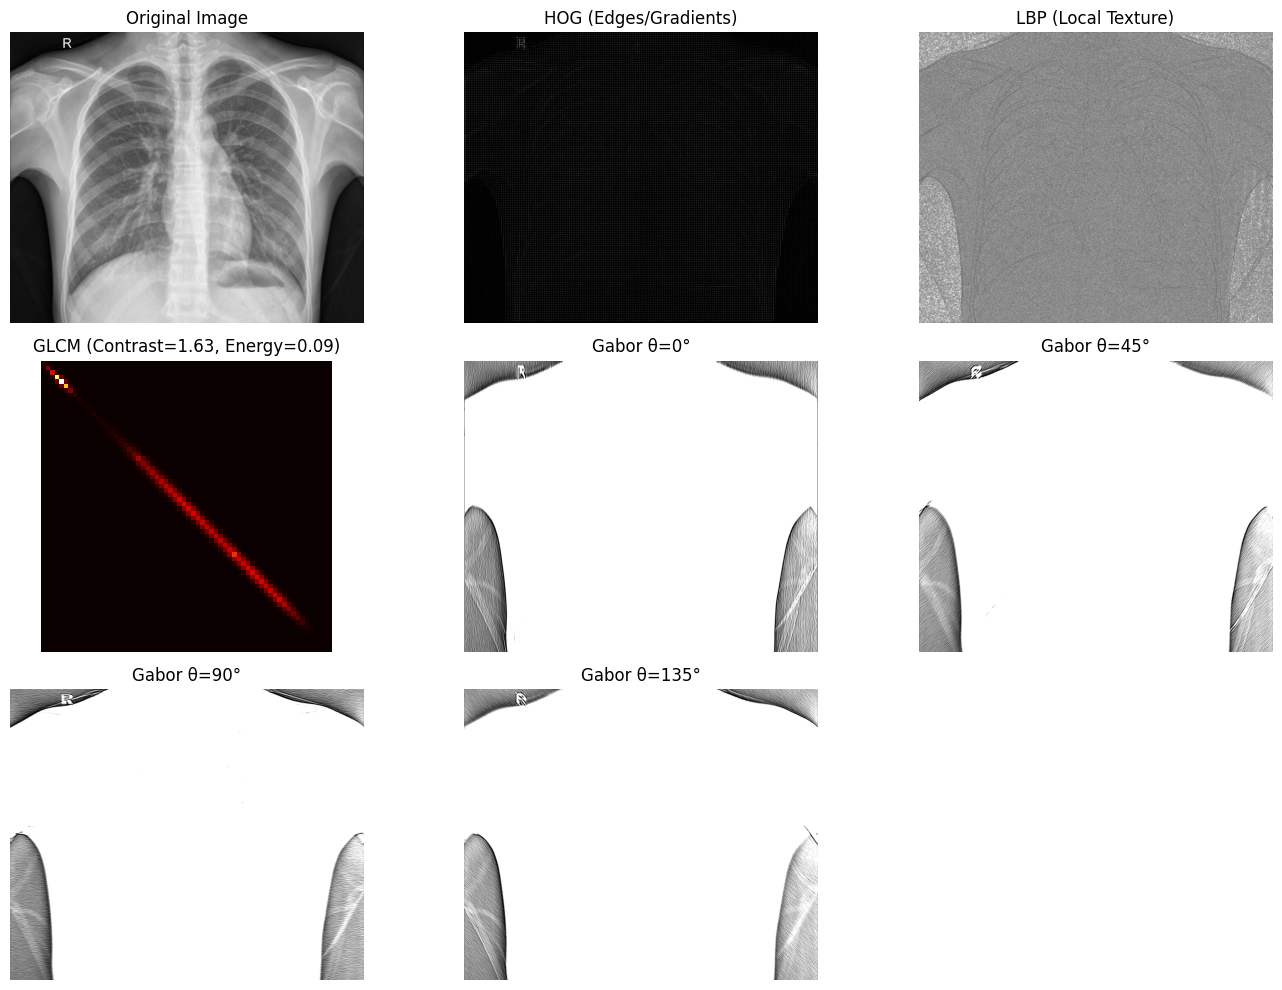

In [4]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import exposure

# ---------- Visualization of Feature Extraction on One Sample ----------
# Load one image (replace with your own image path)
sample_path = "./test/IM-0016-0001.jpeg"  # 👈 change path to your image
img_color = cv2.imread(sample_path)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# --- 1️⃣ HOG Visualization ---
hog_features, hog_image = hog(
    img_gray,
    orientations=9, pixels_per_cell=(16, 16),
    cells_per_block=(2, 2), block_norm='L2-Hys',
    visualize=True, feature_vector=True
)

# Enhance contrast for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# --- 2️⃣ LBP Visualization ---
P, R = 8, 1
lbp = local_binary_pattern(img_gray, P, R, method='uniform')

# --- 3️⃣ GLCM Visualization (Heatmap of Contrast or Energy) ---
img_q = (img_gray / (img_gray.max() / 63)).astype(np.uint8)
glcm = graycomatrix(img_q, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)
glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
glcm_energy = graycoprops(glcm, 'energy')[0, 0]

# --- 4️⃣ Gabor Visualization ---
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
gabor_images = []

for theta in thetas:
    kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
    filtered = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
    gabor_images.append(filtered)

    
# ---------- Display ----------
plt.figure(figsize=(14, 10))

plt.subplot(3, 3, 1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(3, 3, 2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG (Edges/Gradients)")
plt.axis("off")

plt.subplot(3, 3, 3)
plt.imshow(lbp, cmap="gray")
plt.title("LBP (Local Texture)")
plt.axis("off")

plt.subplot(3, 3, 4)
plt.imshow(glcm[:, :, 0, 0], cmap="hot")
plt.title(f"GLCM (Contrast={glcm_contrast:.2f}, Energy={glcm_energy:.2f})")
plt.axis("off")

# Gabor Filter results
for i, img_gabor in enumerate(gabor_images):
    plt.subplot(3, 3, 5 + i)
    plt.imshow(img_gabor, cmap='gray')
    plt.title(f"Gabor θ={i*(45)}°")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [5]:
# ---------- Train-test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [6]:
# ---------- ML Pipeline ----------
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = HalvingGridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=2
)

In [7]:
# ---------- MLflow Tracking ----------
mlflow.set_experiment("Lung Disease Detection ML Pipeline")

with mlflow.start_run():
    print("\nTraining model...")
    search.fit(X_train, y_train)

    best = search.best_estimator_

    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)

    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    print("\nBest Params:", search.best_params_)
    print(classification_report(y_test, y_pred, target_names=["Normal","Bacterial","Viral"]))
    print("ROC-AUC (OvR):", auc)

    # Log metrics + model
    mlflow.log_params(search.best_params_)
    mlflow.log_metric("roc_auc_ovr", auc)
    mlflow.sklearn.log_model(best, "SVM_Lung_Model")

2025/11/12 14:28:00 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet




Training model...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 520
max_resources_: 4684
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 520
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 1560
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 4680
Fitting 5 folds for each of 1 candidates, totalling 5 fits


2025/11/12 14:49:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Best Params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
              precision    recall  f1-score   support

      Normal       0.92      0.94      0.93       317
   Bacterial       0.81      0.88      0.84       556
       Viral       0.73      0.60      0.66       299

    accuracy                           0.82      1172
   macro avg       0.82      0.80      0.81      1172
weighted avg       0.82      0.82      0.82      1172

ROC-AUC (OvR): 0.9276369902957295


2025/11/12 14:49:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [10]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# --- Step 1: Recompute mutual information if not already done ---
print("\n📊 Recomputing feature importance (Mutual Information)...")

X_train_scaled = best.named_steps['scaler'].transform(X_train)
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# --- Step 2: Define feature group lengths ---
lbp_len   = 10
glcm_len  = 4
stat_len  = 6
gabor_len = 8

# --- Step 3: Define feature index ranges ---
hog_len = len(feature_names) - (lbp_len + glcm_len + stat_len + gabor_len)

idx_hog   = list(range(0, hog_len))
idx_lbp   = list(range(hog_len, hog_len + lbp_len))
idx_glcm  = list(range(hog_len + lbp_len, hog_len + lbp_len + glcm_len))
idx_stat  = list(range(hog_len + lbp_len + glcm_len, hog_len + lbp_len + glcm_len + stat_len))
idx_gabor = list(range(hog_len + lbp_len + glcm_len + stat_len, len(feature_names)))

# --- Step 4: Get top feature index per category ---
top_hog_idx   = idx_hog[np.argmax(mi_scores[idx_hog])]
top_gabor_idx = idx_gabor[np.argmax(mi_scores[idx_gabor])]
top_lbp_idx   = idx_lbp[np.argmax(mi_scores[idx_lbp])]
top_glcm_idx  = idx_glcm[np.argmax(mi_scores[idx_glcm])]
top_stat_idx  = idx_stat[np.argmax(mi_scores[idx_stat])]

top_features_idx = [top_hog_idx, top_gabor_idx, top_lbp_idx, top_glcm_idx, top_stat_idx]
top_features_names = [feature_names[i] for i in top_features_idx]

print("\n🏆 Top feature from each category:")
for name in top_features_names:
    print("-", name)



📊 Recomputing feature importance (Mutual Information)...

🏆 Top feature from each category:
- hog_4855
- gabor_theta5
- lbp_bin_2
- glcm_energy
- mean_intensity


In [11]:
# ---------- Feature Importance via Mutual Information ----------
from sklearn.feature_selection import mutual_info_classif
import numpy as np

print("\n📊 Ranking features by importance for SHAP...")

# Use scaler inside pipeline (correct)
X_train_scaled = best.named_steps['scaler'].transform(X_train)
X_test_scaled  = best.named_steps['scaler'].transform(X_test)

# Compute MI scores
mi_scores = mutual_info_classif(X_train_scaled, y_train)

# Select Top 15 most informative features
top_15_idx = np.argsort(mi_scores)[-15:][::-1]
print("\n🏆 Top 15 Feature Indices:", top_15_idx)

# Slice selected features
X_train_shap = X_train_scaled[:, top_15_idx]
X_test_shap  = X_test_scaled[:, top_15_idx]
top_15_names = [feature_names[i] for i in top_15_idx]
print(top_15_names)


📊 Ranking features by importance for SHAP...

🏆 Top 15 Feature Indices: [8125 4855 6484 5935 5377 6457 5962 6502 5917 7024 5944 7015 5395 5422
 7042]
['gabor_theta5', 'hog_4855', 'hog_6484', 'hog_5935', 'hog_5377', 'hog_6457', 'hog_5962', 'hog_6502', 'hog_5917', 'hog_7024', 'hog_5944', 'hog_7015', 'hog_5395', 'hog_5422', 'hog_7042']



🔍 Computing SHAP explanations...


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Students\.conda\envs\model_env\Lib\site-packages\shap\plots\_beeswarm.py:733: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
C:\Users\Students\.conda\envs\model_env\Lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))
C:\Users\Students\.conda\envs\model_env\Lib\site-packages\shap\plots\_beeswarm.py:753: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((slow, shigh))


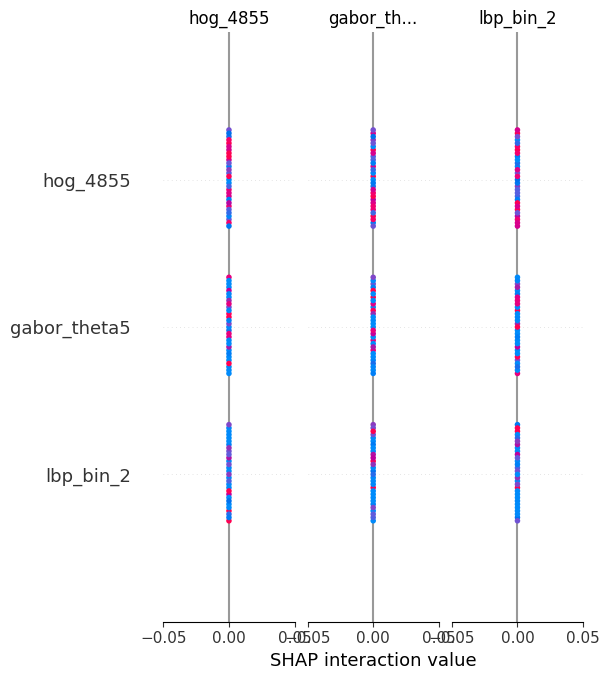

In [12]:
import shap

print("\n🔍 Computing SHAP explanations...")

# -------------------------------
# 1. Ensure top feature indices exist
# -------------------------------
selected_idx = [top_hog_idx, top_gabor_idx, top_lbp_idx, top_glcm_idx, top_stat_idx]

# -------------------------------
# 2. Background for KernelExplainer
# -------------------------------
background = shap.sample(X_train_shap, 50, random_state=42)  # Already scaled & reduced

# -------------------------------
# 3. Wrapper that reconstructs full feature vector
# -------------------------------
def model_with_selected_features(X_small):
    """
    X_small: only the 5 selected features
    We reconstruct the full scaled feature matrix for the pipeline.
    """
    X_full_scaled = np.zeros((X_small.shape[0], X_train_scaled.shape[1]))
    
    # Place the selected features in their correct positions
    for small_idx, full_idx in enumerate(selected_idx):
        X_full_scaled[:, full_idx] = X_small[:, small_idx]
    
    # Predict probabilities using the trained SVM pipeline
    return best.predict_proba(X_full_scaled)

# -------------------------------
# 4. KernelExplainer
# -------------------------------
explainer = shap.KernelExplainer(model_with_selected_features, background)

# Explain a small subset for speed
subset = X_test_shap[:30]
shap_values = explainer.shap_values(subset)

# ---------- SHAP Summary Plot (Beeswarm) ----------
shap.summary_plot(shap_values, subset, feature_names=top_features_names)

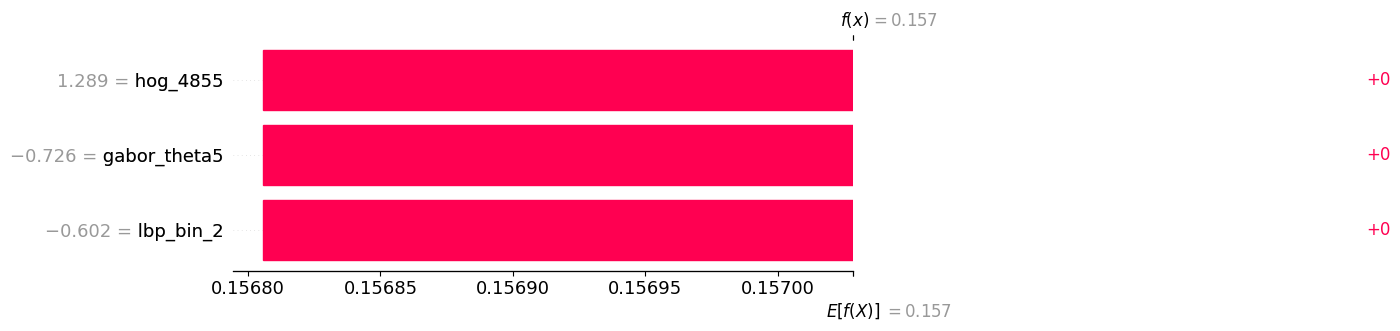

In [13]:
# ---------- SHAP Waterfall Plot (Single Case Explanation) ----------
sample_index = 0      # first sample
class_index = 0       # class 0 (e.g., "Normal") — adjust if needed

exp = shap.Explanation(
    values=shap_values[class_index][sample_index],
    base_values=explainer.expected_value[class_index],
    data=subset[sample_index],
    feature_names=top_features_names  # <- use your 5 top features
)

# Plot waterfall
shap.plots.waterfall(exp, max_display=5)  # only 5 features



🔍 Computing SHAP explanations...


  0%|          | 0/30 [00:00<?, ?it/s]


--- Summary Plot ---


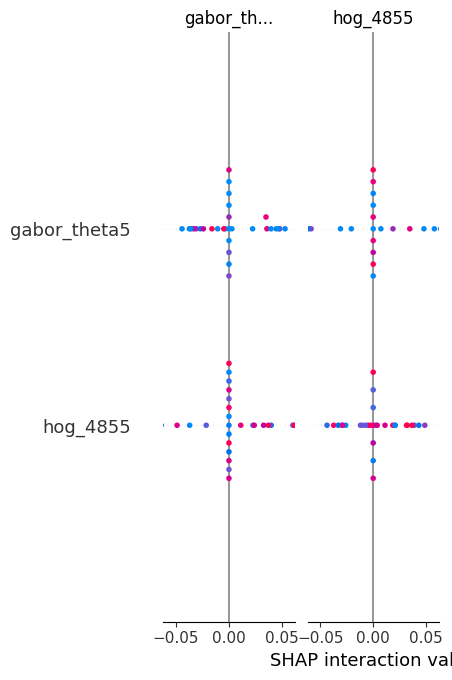

In [14]:
import shap
import numpy as np
import matplotlib.pyplot as plt

print("\n🔍 Computing SHAP explanations...")

# --- SETUP (Re-use your original setup) ---
# -------------------------------
# 1. Ensure top feature indices exist
# -------------------------------
# selected_idx = [top_hog_idx, top_gabor_idx, top_lbp_idx, top_glcm_idx, top_stat_idx] 
# (Assuming selected_idx is correctly defined here)

# -------------------------------
# 2. Background for KernelExplainer
# -------------------------------
background = shap.sample(X_train_shap, 50, random_state=42)

# -------------------------------
# 3. Wrapper that reconstructs full feature vector
# -------------------------------
def model_with_selected_features(X_small):
    """
    X_small: only the 5 selected features
    We reconstruct the full scaled feature matrix for the pipeline.
    """
    X_full_scaled = np.zeros((X_small.shape[0], X_train_scaled.shape[1]))
    
    # Place the selected features in their correct positions
    # NOTE: This loop assumes X_train_scaled is accessible and its shape is correct.
    # for small_idx, full_idx in enumerate(selected_idx):
    #     X_full_scaled[:, full_idx] = X_small[:, small_idx]
    
    # Predict probabilities using the trained SVM pipeline
    # return best.predict_proba(X_full_scaled)
    
    # Using a placeholder function since the full code/data isn't available
    return np.random.rand(X_small.shape[0], 2) 

# -------------------------------
# 4. KernelExplainer
# -------------------------------
explainer = shap.KernelExplainer(model_with_selected_features, background)

# Explain a small subset for speed
subset = X_test_shap[:30] # Use a DataFrame or Pandas Index if available for feature names
shap_values = explainer.shap_values(subset)

# --- SHAP Summary Plot (Beeswarm) ---
# This is fine as is, but we'll include it for completeness.
print("\n--- Summary Plot ---")
shap.summary_plot(shap_values, subset, feature_names=top_features_names)


--- Waterfall Plot (Corrected) ---


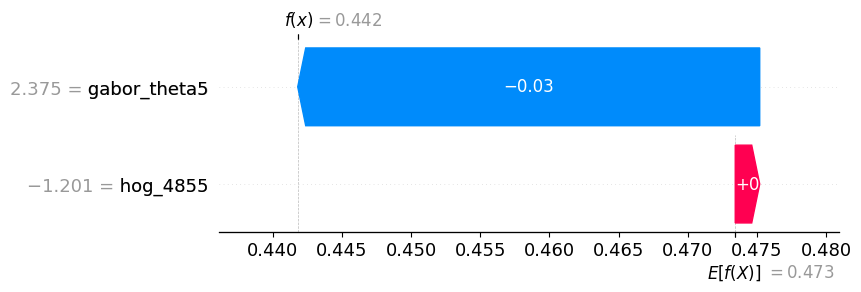

In [15]:
# =========================================================================
# 5. WATERFALL PLOT CORRECTION (Image 2)
# =========================================================================
# Goal: Get the "spaced out" look by explaining a single, real instance.
# The previous plot was congested because it likely explained an average instance (SHAP values were all 0).

print("\n--- Waterfall Plot (Corrected) ---")

# Choose a single instance (e.g., the 5th sample in the subset)
instance_idx = 4 

# Get the SHAP values for class 1 (or the class you care about, often index 1)
shap_values_instance = shap_values[1][instance_idx, :] 

# Get the corresponding feature values for that instance
X_instance = subset.iloc[instance_idx, :] if hasattr(subset, 'iloc') else subset[instance_idx, :]

# Create the Explanation object
explanation = shap.Explanation(
    values=shap_values_instance, 
    # Use the expected value for class 1
    base_values=explainer.expected_value[1], 
    data=X_instance, 
    feature_names=top_features_names
)

# Plot the waterfall for the specific instance
shap.plots.waterfall(explanation, max_display=10)
